In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision.transforms as transforms

# from models import ResNet as resnet_cifar

from model_analysis import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader
from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Initialization')
print('Init Finished!')

Initialization
Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 2048
PATH_Mask1 = '../tb_dir/cifar_exp/test_256bs_150epoch_layer3_open'
PATH = '../tb_dir/cifar_exp/baseline'
model_path = os.path.join(PATH, 'saved_model.pt')
icnn_model_path = os.path.join(PATH_Mask1, 'saved_model.pt')

In [3]:
def load_model(path,channel):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes,index=channel)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(path))
    # model = torch.load(model_path)
    print('Successfully Load Model: ', os.path.basename(path))
    return model

In [4]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [6]:
def predict(model):
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #forward
        outputs = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)
    
        y = labels.data
        batch_size = labels.data.shape[0]
        running_corrects += torch.sum(preds == y)
        true_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    print(dataset_sizes[phase])
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    return epoch_acc

In [7]:

def greedyDropFilter(path):
    baselineModel = load_model(path,-1)
    baseAcc = predict(baselineModel)

    dropAcc = []
    for channel in range(64):
        model = load_model(path,channel)
        acc = predict(model)
        dropAcc.append(baseAcc-acc)
    print(dropAcc)
    return dropAcc
    

In [9]:
def CountFilter(dropAcc):
    accList = np.array(dropAcc)* 100
    accList = np.around(accList,2)
    print(accList)

    Lim = np.around(np.arange(-1,1,0.2),2)
    filterCount = []
    lastCount = 0
    for inx,lim in enumerate(Lim):
        count = 0
        for acc in accList:
            if acc < lim:
                count += 1
        filterCount.append(count-lastCount)
        lastCount = count
    if len(accList) > lastCount:
        maxDrop = len(accList) - lastCount
        filterCount.append(maxDrop)
    print(Lim)
    print(filterCount)   
    return filterCount

    

In [11]:

base_drop_acc = greedyDropFilter(model_path)
icnn_drop_acc = greedyDropFilter(icnn_model_path)
    

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8817
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8817
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8818
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8815
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8816
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8808
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8777
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8809
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8768
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8781
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8808
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8801
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8873
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8876
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8886
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8850
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8882
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[82%]10000
val top1 Acc:0.8916
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[

In [12]:
base_filter_count = CountFilter(base_drop_acc)
icnn_filter_count = CountFilter(icnn_drop_acc)

[ 0.   -0.01  0.02  0.01  0.09  0.19  0.16 -0.08  0.29 -0.01  0.1   0.14
  0.26  0.21  0.69  0.   -0.04  0.18  0.06  0.19 -0.05 -0.07  0.03  0.
  0.14 -0.03 -0.05  0.18 -0.06  0.08  0.15 -0.1   0.36  0.12  0.23  0.16
 -0.08 -0.09  0.16  0.01  0.14 -0.12 -0.02  0.07  0.15 -0.06  0.02  0.33
 -0.1   0.05  0.09  0.01  0.4   0.08  0.49  0.36  0.09  0.16 -0.08 -0.01
  0.33  0.3   0.08  0.17]
[-1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8]
[0, 0, 0, 0, 0, 18, 34, 9, 2, 1]
[ 0.    0.41  0.57  0.31  0.28  0.75  0.19  0.18  0.14  0.28 -0.01 -0.04
  0.43  0.17  0.3   0.38  0.32  0.56  0.35  0.33  0.85  0.29  0.29  0.45
  0.36  0.32  0.27  0.15  0.31 -0.1   0.62  0.48  0.45  0.35  0.71  0.39
  0.05  0.3   0.22  0.94  0.13  0.25  0.22  0.09  0.16 -0.03  0.03  0.17
 -0.03 -0.06  0.02  0.    0.04  0.46  0.31  0.61  0.18  0.3  -0.02  0.11
  0.05 -0.03  0.04 -0.06]
[-1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8]
[0, 0, 0, 0, 0, 9, 19, 22, 8, 4, 2]


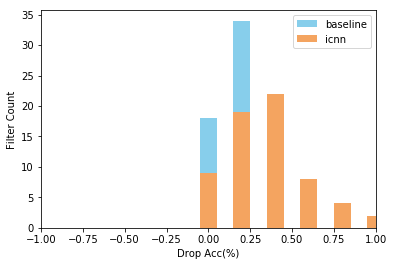

In [16]:
Lim = np.around(np.arange(-1,1,0.2),2)
plt.bar(Lim,base_filter_count,width=0.1,color='#87CEEB',label='baseline')
Lim = np.around(np.arange(-1,1.2,0.2),2)
plt.bar(Lim,icnn_filter_count,width=0.1,color='#F4A460',label='icnn')
plt.xlim([-1,1])
plt.xlabel('Drop Acc(%)')
plt.ylabel('Filter Count')
plt.legend()
plt.show()